# comparing IEX 1 year data vs dukascopy 3 year data

In [1]:
import common
import numpy as np
import pandas as pd

In [2]:
# inputs
iex_path = r"C:\Users\asaf\Desktop\DS_workshop-project\stock_market_neural_nets\data\relevant\snp500_from_iex\AAPL.csv"
dukas_path = r"C:\Users\asaf\Desktop\DS_workshop-project\stock_market_neural_nets\data\relevant\dukascopy\BID\AAPL.csv"

## 1) getting data

### 1.1) get IEX data

In [3]:
iex_data = pd.read_csv(iex_path)
common.minimal_IEX_preprocessing(iex_data)
del iex_data['numberOfTrades'], iex_data['notional'], iex_data['average']
iex_data.set_index("datetime", inplace=True)
iex_data.sort_index(inplace=True)

In [4]:
# drop nans
iex_data = iex_data.dropna()

In [5]:
iex_data.head()

,high,low,open,close,volume
datetime,,,,,
2019-04-01 09:30:00,191.645,190.60,191.645,190.65,4320.0
2019-04-01 09:31:00,190.980,190.64,190.700,190.98,3246.0
2019-04-01 09:32:00,191.090,190.78,191.060,190.93,2253.0
2019-04-01 09:33:00,191.010,190.76,190.980,190.83,2241.0
2019-04-01 09:34:00,190.760,190.60,190.760,190.70,1069.0


### 1.2) get dukascopy data

In [6]:
dukas_data = pd.read_csv(dukas_path)

# rename columns
new_cols_map = {col: col.lower() for col in dukas_data}
new_cols_map['Local time'] = "datetime"
dukas_data.rename(columns=new_cols_map, inplace=True)

# convert datetime type (string to datetime)
dukas_data['datetime'] = dukas_data['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
dukas_data['datetime'] = pd.to_datetime(dukas_data['datetime'], format='%d.%m.%Y %H:%M')

dukas_data.set_index("datetime", inplace=True)

In [7]:
dukas_data.head()

,open,high,low,close,volume
datetime,,,,,
2017-01-26 00:00:00,121.864,121.864,121.864,121.864,0.0
2017-01-26 00:01:00,121.864,121.864,121.864,121.864,0.0
2017-01-26 00:02:00,121.864,121.864,121.864,121.864,0.0
2017-01-26 00:03:00,121.864,121.864,121.864,121.864,0.0
2017-01-26 00:04:00,121.864,121.864,121.864,121.864,0.0


## compare data sources

since IEX data is shorter than dukascopy's data, <br/>
we will compare each IEX data point to its corresponding data point in dukascopy data set. <br/>

apply shift to dukascopy timestamps - so each trading day starts in 9:30 (instead of 16:30) and ends in 16:00 (instead of 23:00), <br/>
just like the IEX dataset does.

In [8]:
dukas_data.index = dukas_data.index + pd.Timedelta(hours=-7)

put datasets "side by side"

In [9]:
merged_data = pd.merge(iex_data,dukas_data, how='inner', left_index=True, right_index=True)

In [10]:
merged_data.head()

,high_x,low_x,open_x,close_x,volume_x,open_y,high_y,low_y,close_y,volume_y
datetime,,,,,,,,,,
2019-04-01 09:30:00,191.645,190.60,191.645,190.65,4320.0,191.548,191.618,190.607,190.607,706748.0087
2019-04-01 09:31:00,190.980,190.64,190.700,190.98,3246.0,190.607,191.008,190.548,190.968,623174.0117
2019-04-01 09:32:00,191.090,190.78,191.060,190.93,2253.0,190.968,191.170,190.748,190.857,854170.0244
2019-04-01 09:33:00,191.010,190.76,190.980,190.83,2241.0,190.888,191.028,190.727,190.747,729126.9898
2019-04-01 09:34:00,190.760,190.60,190.760,190.70,1069.0,190.747,190.753,190.528,190.721,992367.0292


In [11]:
merged_data['diff'] = merged_data['close_x'] - merged_data['close_y']

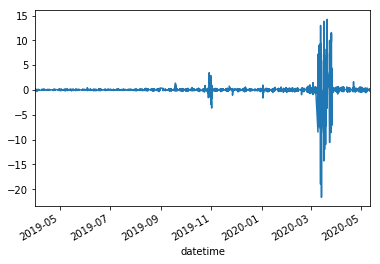

In [24]:
merged_data['diff'].plot()

weird results

what is the average difference?

In [13]:
merged_data['diff'].abs().mean()

0.2256552490496233

how many big (more than 5$) outliers we have?

In [14]:
merged_data[merged_data['diff'].abs()>5]['diff'].count()

1145

what is the average difference without those outliers?

In [15]:
merged_data[merged_data['diff'].abs()<5]['diff'].mean()

0.024995899255755155

2.5 cent, much better

lets see the difference distribution

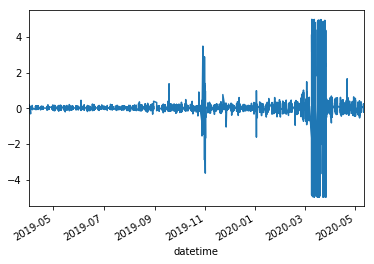

In [16]:
merged_data[merged_data['diff'].abs()<5]['diff'].plot()

lets have a closer look at the outliers - what are they? why they happen? do they have somthing in common?

In [17]:
outliers = merged_data[merged_data['diff'].abs()>5]

# focus on the things we campared - close prices
outliers = outliers[['close_x', 'close_y', 'diff']]

In [18]:
outliers

,close_x,close_y,diff
datetime,,,
2020-03-09 09:30:00,265.270,273.748,-8.478
2020-03-09 09:31:00,267.100,273.598,-6.498
2020-03-09 09:32:00,267.780,273.728,-5.948
2020-03-09 09:33:00,267.445,275.158,-7.713
2020-03-09 09:34:00,267.450,274.527,-7.077
...,...,...,...
2020-03-26 15:39:00,251.350,257.778,-6.428
2020-03-26 15:40:00,252.130,257.778,-5.648
2020-03-26 15:41:00,252.400,257.778,-5.378


In [19]:
outliers.describe()

,close_x,close_y,diff
count,1145.000000,1145.000000,1145.000000
mean,251.115996,251.584763,-0.468768
std,15.682341,17.057786,8.401455
min,212.890000,212.848000,-21.628000
25%,242.230000,241.827000,-6.858000
50%,251.940000,250.517000,-5.068000
75%,260.135000,261.518000,6.738000
max,281.630000,285.358000,14.233000


are the outliers grouped in specific days? or are they sparsed across the whole dataset?

In [20]:
outliers_dates = np.unique(outliers.index.date)
outliers_dates

array([datetime.date(2020, 3, 9), datetime.date(2020, 3, 10),
       datetime.date(2020, 3, 12), datetime.date(2020, 3, 13),
       datetime.date(2020, 3, 16), datetime.date(2020, 3, 17),
       datetime.date(2020, 3, 18), datetime.date(2020, 3, 19),
       datetime.date(2020, 3, 20), datetime.date(2020, 3, 23),
       datetime.date(2020, 3, 24), datetime.date(2020, 3, 25),
       datetime.date(2020, 3, 26)], dtype=object)

In [21]:
len(np.unique(outliers_dates))

13

all 1145 outlier data points are densed within 13 different days

what if we drop those days from our merged dataset? <br/>
how much of a difference will dropping those outlier days make?

In [22]:
no_outliers = merged_data[np.isin(merged_data.index.date, outliers_dates, invert=True)]

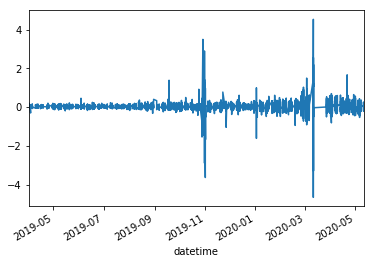

In [23]:
no_outliers['diff'].plot()

better, but not the best